In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

from torchvision import datasets, transforms
import torchvision
import matplotlib.pyplot as plt

import numpy as np

In [1]:
from transformers import ViTImageProcessor, ViTForImageClassification
from PIL import Image
import requests

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [7]:
#This model is a transformer from the pytorch transformers, this one is based
#On the paper "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale"


from torchvision import datasets, models, transforms


modelTransformer = models.vit_b_16(pretrained=False)
modelTransformer.heads.head = nn.Linear(modelTransformer.heads.head.in_features, 3)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [8]:
modelTransformer = modelTransformer.to(device)

In [10]:
def get_acuracy(modelTrain,featuresAndLabels):

  modelTrain.eval()

  error_over = 0
  i = 0
  for feature, label in featuresAndLabels:
    feature = feature.to(device)
    if torch.argmax(modelTrain(feature.unsqueeze(0))).item() != label:
      error_over+=1
      print(i)
    i+=1

  modelTrain.train()

  return error_over/len(featuresAndLabels)

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
#Standard transformations given from: Transfer Learning for Computer Vision Tutorial, https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

img_to_tensor = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
trainingDataset = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/PlantDataset/training_database',transform=img_to_tensor)

validationDataset = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/PlantDataset/validation_database',transform=img_to_tensor)

testingDataset = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/PlantDataset/testing_database',transform=img_to_tensor)

In [12]:
def trainClassifier(model,featuresAndLabelsTraining,featuresAndLabelsValidation, batch_size=64, num_epochs=5, learning_rate=1e-3):
    torch.manual_seed(42)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate)

    train_loader = torch.utils.data.DataLoader(featuresAndLabelsTraining,
                                               batch_size=batch_size,
                                               shuffle=True)

    model.train()

    number, error = [], []

    for epoch in range(num_epochs):
        # with torch.no_grad():
        #     actualError = get_acuracy(model, featuresAndLabelsValidation)
        #     error.append(actualError)
        #     print(actualError)
        #     number.append(epoch)

        print(epoch)
        it = 0
        for feature,label in iter(train_loader):
            feature = feature.to(device)
            label = label.to(device)
            output = model(feature)
            output = output.view(output.size(0), -1)

            loss = criterion(output, label)
            loss.backward(retain_graph=True)
            optimizer.step()
            optimizer.zero_grad()
            print(it)
            it += 1


    return number, error

In [15]:
trainClassifier(modelTransformer,trainingDataset,validationDataset,batch_size=16, learning_rate= 1e-5, num_epochs=5)

0


KeyboardInterrupt: 

In [16]:
state_dict = torch.load('/content/drive/MyDrive/TransformerWeights/modelTransformer.pt')
modelTransformer.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
get_acuracy(modelTransformer,testingDataset)

577


0.0015503875968992248

In [ ]:
torch.save(modelTransformer.state_dict(), '/content/drive/MyDrive/TransformerWeights/modelTransformer.pt')

This is an image of class:  wheat
The NN guesses that it is:  wheat


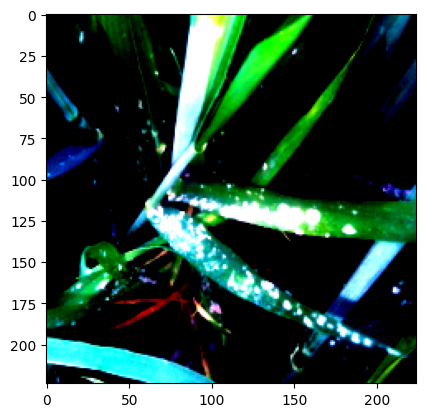

In [ ]:
class_to_idx = validationDataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

test = validationDataset[1111]

testImage = test[0]
print("This is an image of class: ", idx_to_class[test[1]])

print("The NN guesses that it is: ", idx_to_class[torch.argmax(modelTransformer(testImage.unsqueeze(0).to(device)),dim = 1).item()] )



testImage = testImage.permute(1,2,0)

plt.imshow(testImage)